# Project Overview
 
  In this project, We're going to build an item based collaborative recommendation system . In this recommender system , items will be clustered based on rating of item given by users and item will be recommends based on similar items.
  

## Data-Sets
  This dataset contain 2 different file.
  
  1) movies : this file contain movieId,title of movies and genre of movies.
  
  2) rating : this file contain ratings given by userId to MovieId and rating given to movieId.
  
  This dataset contain 9000 unique movies and 600 unique user . Total ratings in this dataset is around 300,000.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5n_Z8UvCb-X9Aq3YMvSWUNlj03iE2DEmVPmf-SbCC456sB6X9vnek
Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Data/ml-latest-small"

/content/drive/MyDrive/Data/ml-latest-small


In [3]:
# Import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Read the dataset files
movies_df = pd.read_csv("movies.csv")
movies_df.head()


,MovieID,Title,Genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# Read the dataset files
ratings_df = pd.read_csv('ratings.csv')
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# Calculate the unique users in the dataset
unique_users = ratings_df.UserID.nunique(dropna = True)
print("Number of unique user:", unique_users)

# Calculate the unique movies in the dataset
unique_movies = ratings_df.MovieID.nunique(dropna = True)
print("Number of unique movies:", unique_movies)

Number of unique user: 610
Number of unique movies: 9724


In [7]:
# Creating item user matrix
# we need to check how many ratings we have and how many are NaN.

total_ratings = unique_users*unique_movies
rating_present = ratings_df.shape[0]
no_ratings = total_ratings - rating_present 

print("Sum of total movies not rated each user : ", no_ratings)
print("Sparsity of user-item matrix is : ", no_ratings / total_ratings)

Sum of total movies not rated each user :  5830804
Sparsity of user-item matrix is :  0.9830003169443864


## Data Exploration for Ratings

In [8]:
# We can see that most of the movies are rated very rarely ..
# so we can remove those movies which are rated less than 25 times.

# this rating count doesn't have count of rating 0
rating_count = pd.DataFrame(ratings_df.groupby('Rating').size(),columns=['count'])
print('Ratings count which gives information about which rating (on scale of 0 t0 5) is more frequent:')
print(rating_count, '\n')

# append rating count for rating 0
rating_count= rating_count.append(pd.DataFrame({'count':no_ratings},index = [0])).sort_index()
print('Ratings count with appending the rating not provided values :')
print(rating_count, '\n')

Ratings count which gives information about which rating (on scale of 0 t0 5) is more frequent:
        count
Rating       
0.5      1370
1.0      2811
1.5      1791
2.0      7551
2.5      5550
3.0     20047
3.5     13136
4.0     26818
4.5      8551
5.0     13211 

Ratings count with appending the rating not provided values :
       count
0.0  5830804
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211 



In [9]:
# No of times the movie has been rated
movie_freq = pd.DataFrame(ratings_df.groupby('MovieID').size(),columns=['count'])

print('Frequency count of each movie rated : ')
movie_freq.head()

Frequency count of each movie rated : 


,count
MovieID,
1,215
2,110
3,52
4,7
5,49


In [10]:
# From data analysis in excel, we calculated the threshold value of rating
# frequency which is the movies with less ratings frequency.
threshold_rating = 25

# First take out the movie id  for which movie is rated more than threshold value
# than keep only this movies in our original ratings dataframe

# Original Dataset has shape of (10325,1)
print('Shape of the movies frequency : ', movie_freq.shape)

# Reduced Dataset has shape of (1064,1)
print('Shape of the movies with frequency more than threshold rating: ', movie_freq.query('count>= @threshold_rating').shape)

popular_moviesId = list(set(movie_freq.query('count>=@threshold_rating').index))

# Ratings after dropping non popular movies
ratings_with_popular_movies = ratings_df[ratings_df.MovieID.isin(popular_moviesId)]

print("No of unique movies present in dataset : ", unique_movies)
print("No of movies which are rated more than 10 times : ", len(popular_moviesId))
print('Shape of the ratings : ', ratings_df.shape)
print('Shape of ratings with popular movies : ', ratings_with_popular_movies.shape)

Shape of the movies frequency :  (9724, 1)
Shape of the movies with frequency more than threshold rating:  (1050, 1)
No of unique movies present in dataset :  9724
No of movies which are rated more than 10 times :  1050
Shape of the ratings :  (100836, 4)
Shape of ratings with popular movies :  (62518, 4)


In [11]:
# From the plot we can interpret that, there are very few users who are interested 
# in giving rating to movies, thus find out the users who gives rating more than 25 times.

# No of movies rated by the each user
user_freq = pd.DataFrame(ratings_df.groupby('UserID').size(),columns=['count'])

print('Frequency movies rated by each users : ')
user_freq.head()

Frequency movies rated by each users : 


,count
UserID,
1,232
2,29
3,39
4,216
5,44


In [12]:
# From data analysis in excel, we calculated the threshold value of rating
# frequency which is the movies with less ratings frequency.

threshold_user = 25
active_user = list(set(user_freq.query('count>=@threshold_user').index))

# Update your ratings with popular movies
ratings_with_popular_movies_with_active_user = ratings_with_popular_movies[ratings_with_popular_movies.UserID.isin(active_user)]

print('Dimensions of ratings with Popular Movies : ', ratings_with_popular_movies.shape)
print('Dimensions of ratings with Popular Movies with Active User : ', ratings_with_popular_movies_with_active_user.shape)
print("Unique User : ", unique_users)
print("Active User : ", len(active_user))
print("Unique Movies : ", unique_movies)
print("Popular Movies : ", len(popular_moviesId))

Dimensions of ratings with Popular Movies :  (62518, 4)
Dimensions of ratings with Popular Movies with Active User :  (61433, 4)
Unique User :  610
Active User :  547
Unique Movies :  9724
Popular Movies :  1050


## Building the KNN model
here we are going to use an unsupervised learning algorithm known as NearestNeibhours. so we have to reshape/prepare our dataset into a format which can be given as parameter. we will pivot our final dataset into a ITEM-USER matrix and empty cell with 0.( because KNN model calculates distance between two points. )

From the above observation, we can see the reduce in number of user and movies in our dataset. While dimensions of rating dataset doesn't change because we are considering only movies that are reated more than threshold and users that do give rating more than threshold values. 

---

The reduce in dimensions was necessary for following reasons:
* It reduces the sparsity
* KNN algorithm doesn't work properly in case of large number of dimension



In [13]:
sparsity = ((unique_users * unique_movies) - ratings_with_popular_movies.shape[0]) / (unique_users * unique_movies)
sparsity_with_modified_ratings = ((len(active_user) * len(popular_moviesId)) - ratings_with_popular_movies_with_active_user.shape[0]) / (len(active_user) * len(popular_moviesId))
print("Sparsity of previous ratings : ", sparsity)
print("Sparsity of modified ratings : ", sparsity_with_modified_ratings)

Sparsity of previous ratings :  0.9894602504535002
Sparsity of modified ratings :  0.8930390876643162


* Sparsity in previous ratings dataframe : = 0.9905941627640602 
* Sparsity in modified ratings dataframe : = 0.9006580505991346

So it's cleared that we have reduced the sparsity by removing non popular movies and non active user.

In [14]:
user_matrix = ratings_with_popular_movies_with_active_user
print(user_matrix.shape)
item_user_matrix = user_matrix.pivot(index='MovieID',columns = 'UserID',values='Rating').fillna(0)
print(item_user_matrix)

(61433, 4)
UserID   1    2    3    4    5    6    7    ...  604  605  606  607  608  609  610
MovieID                                     ...                                   
1        4.0  0.0  0.0  0.0  4.0  0.0  4.5  ...  3.0  4.0  2.5  4.0  2.5  3.0  5.0
2        0.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  5.0  3.5  0.0  0.0  2.0  0.0  0.0
3        4.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  0.0  0.0  0.0  0.0  2.0  0.0  0.0
5        0.0  0.0  0.0  0.0  0.0  5.0  0.0  ...  3.0  0.0  0.0  0.0  0.0  0.0  0.0
6        4.0  0.0  0.0  0.0  0.0  4.0  0.0  ...  3.0  0.0  0.0  0.0  0.0  0.0  5.0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
148626   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  4.0
152081   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  4.0
164179   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  5.0
166528   0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.

In [15]:
# create a mapper which maps movie index and its title
movieToIndex = {
    movie:i for i,movie in enumerate(list(movies_df.set_index('MovieID').loc[item_user_matrix.index].Title))
}

In [ ]:
# create a sparse matrix for more efficient calculations
from scipy.sparse import csr_matrix

item_user_matrix_sparse = csr_matrix(item_user_matrix.values)
print(item_user_matrix_sparse)

now when a movie name is given as input we need to find that any such movie present in our dataset or not.If it is not present
then we cant recommend anything .
so for string matching we are going to use fuzzy matching , based on result of fuzzy matching , a list of recommedation will be generated. lets create a function which take parameters (input_string , mapper=movie_to_index) .
This fucntion will return movie_id of movie title which is best match with input string .
It also prints the all matches .

In [17]:
pip install fuzzywuzzy

In [18]:
# fuzzy_movie_string_matching
from fuzzywuzzy import fuzz

def fuzzy_movie_string_matching(input_str,mapper,print_matches):
    # match_movie is list of tuple of 3 values(movie_name,index,fuzz_ratio)
    match_movie = []
    for movie,index in mapper.items():
        current_ratio = fuzz.ratio(movie.lower(),input_str.lower())
        if(current_ratio>=50):
            match_movie.append((movie,index,current_ratio))
     
    # sort the match_movie with respect to ratio 

    if len(match_movie)==0:
        print("No such movie is present in dataset\n")
        return -1

    match_movie = sorted(match_movie,key =lambda x:x[2])[::-1]

    if print_matches == True:
        print("Some matching input string are\n")
        for title,index,ratio in match_movie:
            print(title,index,'\n')
     
        
    return match_movie[0][1]    

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [19]:
# define the model
from sklearn.neighbors import NearestNeighbors
model = NearestNeighbors(metric='minkowski',algorithm = 'kd_tree',n_neighbors=25,n_jobs=-1)

In [20]:
# create a function which takes a movie name and make recommedation for it
def recommendation(input_str,data,model,mapper,n_recommendation):
    print("Recommendation in progress...\n")
    model.fit(data)
    
    index = fuzzy_movie_string_matching(input_str,mapper,print_matches = False)
    
    if index==-1 :
        print("pls enter a valid movie name\n")
        return 
    
    index_list = model.kneighbors(data[index],n_neighbors=n_recommendation+1,return_distance=False)
    # now we ind of all recommendation
    # build mapper index->title
    indexToMovie={
        index:movie for movie,index in mapper.items()
    }
    

    print("Viewer who watches this movie ",input_str,"also watches following movies.")
    #print(indexList[0][2])
    for i in range(1,index_list.shape[1]):
        print(indexToMovie[index_list[0][i]])
    
    return 

In [21]:
recommendation('Avengers',item_user_matrix_sparse,
               model,movieToIndex,10)

Recommendation in progress...

Viewer who watches this movie  Avengers also watches following movies.
Iron Man 2 (2010)
Guardians of the Galaxy (2014)
Captain America: The Winter Soldier (2014)
X-Men: First Class (2011)
Iron Man 3 (2013)
X-Men: Days of Future Past (2014)
Avengers: Age of Ultron (2015)
Captain America: The First Avenger (2011)
Thor (2011)
Ant-Man (2015)


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


## Important Observations
1. Our model recommends movie which are almost release in similar years.
2. Since we have removed unpopular movies from our dataset , this movie will never be recommend to user



## Analysis in Excel

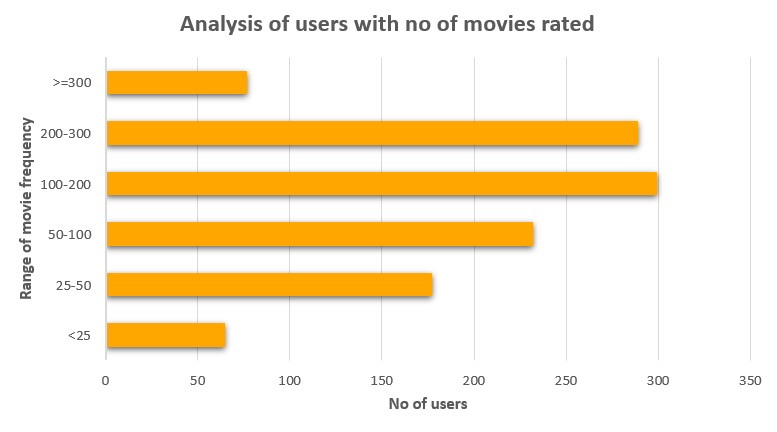

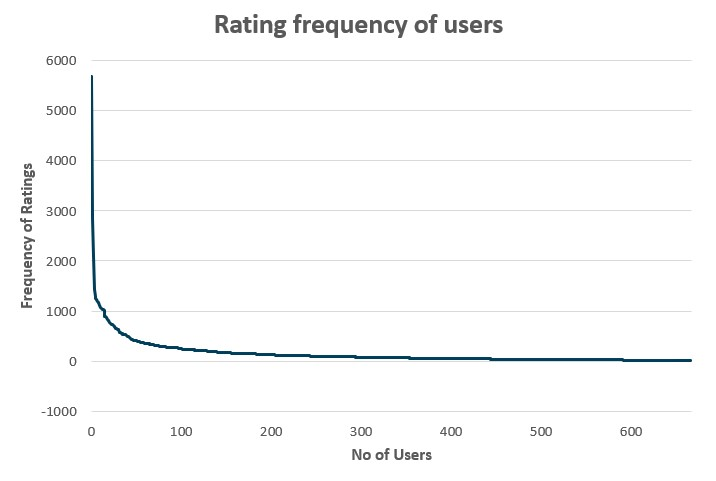

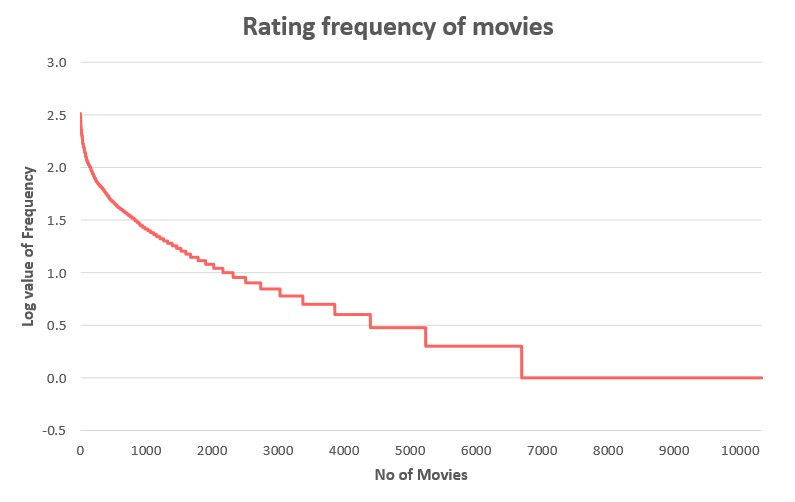

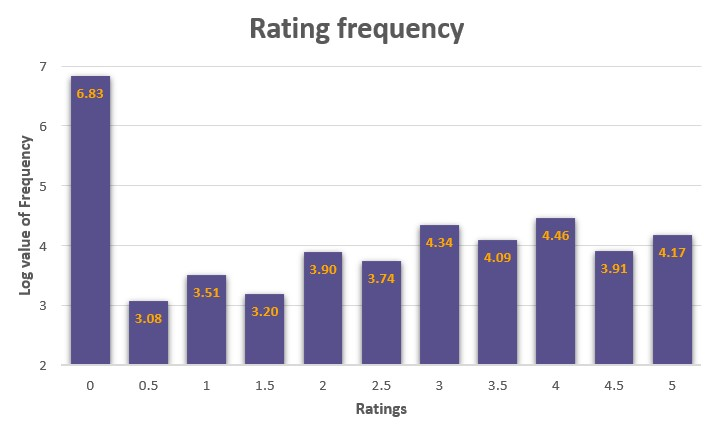

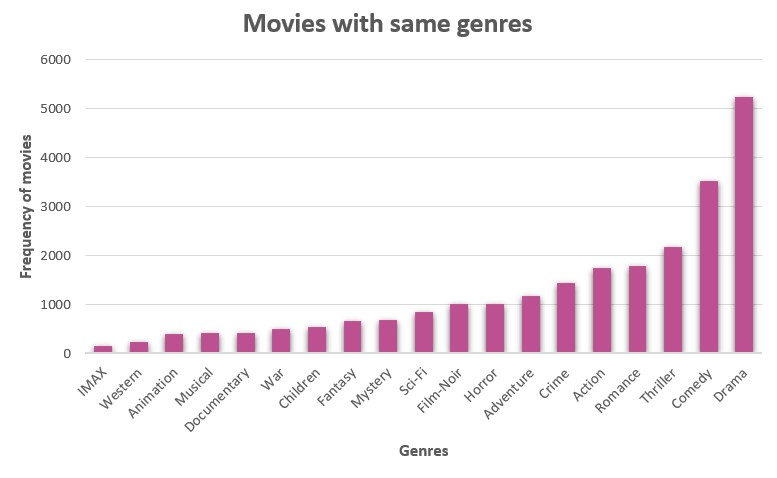

In [22]:
from IPython.display import Image, display
display(Image('/content/drive/MyDrive/Data/ml-results/P1.jpg'))
display(Image('/content/drive/MyDrive/Data/ml-results/P2.jpg'))
display(Image('/content/drive/MyDrive/Data/ml-results/P3.jpg'))
display(Image('/content/drive/MyDrive/Data/ml-results/P4.jpg'))
display(Image('/content/drive/MyDrive/Data/ml-results/P5.jpg'))